# 2. Niveles Lingüísticos II

<a target="_blank" href="https://colab.research.google.com/github/umoqnier/cl-2026-2-lab/blob/main/notebooks/2_niveles_linguisticos_II.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Objetivos

- Comparar enfoques basados en reglas y estadísticos para el análisis morfológico
- Los alumnæs comprenderán la importancia de las etiquetas *POS* en tareas de _NLP_
- Implementar un modelo de etiquetado automático
    - Usando modelos discriminativos _HMMs_
    - Usando modelos condicionales _CRFs_
    - Contrastar ambos enfoques para generación automática de secuencias de etiquetas

In [ ]:
# !uv add nltk scikit-learn sklearn-crfsuite <- Local con uv
!pip install nltk scikit-learn sklearn-crfsuite

Resolved 124 packages in 7ms
Audited 120 packages in 17ms


In [1]:
import re
from collections import defaultdict

import matplotlib.pyplot as plt
import nltk
import pandas as pd
import requests as r
from nltk.corpus import cess_esp

from rich import print as rprint

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import CRF

## Morfología

<center><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/29/Flexi%C3%B3nGato-svg.svg/800px-Flexi%C3%B3nGato-svg.svg.png" width=200></center>

> De <a href="//commons.wikimedia.org/wiki/User:KES47" class="mw-redirect" title="User:KES47">KES47</a> - <a href="//commons.wikimedia.org/wiki/File:Flexi%C3%B3nGato.png" title="File:FlexiónGato.png">File:FlexiónGato.png</a> y <a href="//commons.wikimedia.org/wiki/File:Nuvola_apps_package_toys_svg.svg" title="File:Nuvola apps package toys svg.svg">File:Nuvola apps package toys svg.svg</a>, <a href="http://www.gnu.org/licenses/lgpl.html" title="GNU Lesser General Public License">LGPL</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=27305101">Enlace</a>

El análisis morfológico es la determinación de las partes que componen la palabra y su representación lingüística, es una especie de etiquetado

Los elementos morfológicos son analizados para:

- Determinar la función morfológica de las palabras
- Hacer filtrado y pre-procesamiento de text

### Análisis morfológico basado en reglas

Recordemos que podemos hacer un analizador morfológico haciendo uso de un transductor que vaya leyendo y haciendo transformaciones en una cadena. Formalmente:

* $Q = \{q_0, \ldots, q_T\}$ conjunto finito de estados.
* $\Sigma$ es un alfabeto de entrada.
* $q_0 \in Q$ es el estado inicial.
* $F \subseteq Q$ es el conjunto de estados finales.

Un transductor es una 6-tupla $T = (Q, \Sigma, \Delta, q_0, F, \sigma)$ tal que

* $\Delta$ es un alfabeto de salida teminal
* $\Sigma$ es un alfabeto de entrada no terminal
* $\sigma: Q \times \Sigma \times \Delta \longrightarrow Q$ función de transducción

#### Ejemplo: Parsing con expresiones regulares

Con fines de prácticidad vamos a _imitar_ el comportamiento de un transductor utilizando el modulo de python `re`

La estructura del sustantivo en español es:

` BASE+AFIJOS (marcas flexivas)   --> Base+DIM+GEN+NUM`

In [4]:
palabras = [
    'niño',
    'niños',
    'niñas',
    'niñitos',
    'gato',
    'gatos',
    'gatitos',
    'perritos',
    'paloma',
    'palomita',
    'palomas',
    'flores',
    'flor',
    'florecita',
    'lápiz',
    'lápices',
    # 'chiquitititititos',
    #'curriculum', # curricula
    #'campus', # campi
]

In [5]:
def morph_parser_rules(words: list[str]) -> list[str]:
    """Aplica reglas morfológicas a una lista de palabras para realizar
    un análisis morfológico.

    Parameters:
    ----------
    words : list of str
        Lista de palabras a las que se les aplicarán las reglas morfológicas.

    Returns:
    -------
    list of str
        Una lista de palabras después de aplicar las reglas morfológicas.
    """

    # Lista para guardar las palabras parseadas
    morph_parsing = []

    # Reglas que capturan ciertos morfemas
    # {ecita, itos, as, os}
    for w in words:
        # ecit -> DIM
        R0 = re.sub(r"([^ ]+)ecit([a|o|as|os])", r"\1-DIM\2", w)
        # it -> DIM
        R1 = re.sub(r"([^ ]+)it([a|o|as|os])", r"\1-DIM\2", R0)
        # a(s) -> FEM
        R2 = re.sub(r"([^ ]+)a(s)", r"\1-FEM\2", R1)
        # a -> FEM
        R3 = re.sub(r"([^ ]+)a\b", r"\1-FEM", R2)
        # o(s) -> MSC
        R4 = re.sub(r"([^ ]+)o(s)", r"\1-MSC\2", R3)
        # o .> MSC
        R5 = re.sub(r"([^ ]+)o\b", r"\1-MSC", R4)
        # es -> PL
        R6 = re.sub(r"([^ ]+)es\b", r"\1-PL", R5)
        # s -> PL
        R7 = re.sub(r"([^ ]+)s\b", r"\1-PL", R6)
        # Sustituye la c por z cuando es necesario
        parse = re.sub(r"c-", r"z-", R7)

        # Guarda los parseos
        morph_parsing.append(parse)
    return morph_parsing

In [6]:
def prettify_tags(word: str) -> str:
    tags = {
        "DIM": "[b bright_yellow]DIM[/]",
        "FEM": "[b green3]FEM[/]",
        "MSC": "[b medium_purple1]MSC[/]",
        "PL": "[b deep_sky_blue1]PL[/]",
    }
    for tag, pretty_tag in tags.items():
        word = word.replace(tag, pretty_tag)
    return word

In [9]:
morph_parsing = morph_parser_rules(palabras)
for palabra, parseo in zip(palabras, morph_parsing):
    rprint(palabra, "-->", prettify_tags(parseo))

niño --> niñ-MSC

niños --> niñ-MSC-PL

niñas --> niñ-FEM-PL

niñitos --> niñ-DIM-MSC-PL

gato --> gat-MSC

gatos --> gat-MSC-PL

gatitos --> gat-DIM-MSC-PL

perritos --> perr-DIM-MSC-PL

paloma --> palom-FEM

palomita --> palom-DIM-FEM

palomas --> palom-FEM-PL

flores --> flor-PL

flor --> flor

florecita --> flor-DIM-FEM

lápiz --> lápiz

lápices --> lápiz-PL

#### Preguntas 🤔
- ¿Qué pasa con las reglas en lenguas donde son más comunes los prefijos y no los sufijos?
- ¿Cómo podríamos identificar características de las lenguas?

#### Herramientas para hacer sistemas de análisis morfológico basados en reglas

- [Apertium](https://en.wikipedia.org/wiki/Apertium)
- [Foma](https://github.com/mhulden/foma/tree/master)
- [Helsinki Finite-State Technology](https://hfst.github.io/)
- Ejemplo [proyecto](https://github.com/apertium/apertium-yua) de analizador morfológico de Maya Yucateco
- Ejemplo normalizador ortográfico del [Náhuatl](https://github.com/ElotlMX/py-elotl/tree/master)


También se pueden utilizar diferentes métodos de aprendizaje de máquina para realizar análisis/generación morfológica. En los últimos años ha habido un shared task de [morphological reinflection](https://github.com/sigmorphon/2023InflectionST) para poner a competir diferentes métodos

### Segmentación morfológica

#### Corpus: [SIGMORPHON 2022 Shared Task on Morpheme Segmentation](https://github.com/sigmorphon/2022SegmentationST/tree/main)

- Shared task donde se buscaba convertir las palabras en una secuencia de morfemas
- Dividido en dos partes:
    - Segmentación a nivel de palabras (nos enfocaremos en esta)
    - Segmentación a nivel oraciones

#### Track: words

| word class | Description                      | English example (input ==> output)     |
|------------|----------------------------------|----------------------------------------|
| 100        | Inflection only                  | played ==> play @@ed                   |
| 010        | Derivation only                  | player ==> play @@er                   |
| 101        | Inflection and Compound          | wheelbands ==> wheel @@band @@s        |
| 000        | Root words                       | progress ==> progress                  |
| 011        | Derivation and Compound          | tankbuster ==> tank @@bust @@er        |
| 110        | Inflection and Derivation        | urbanizes ==> urban @@ize @@s          |
| 001        | Compound only                    | hotpot ==> hot @@pot                   |
| 111        | Inflection, Derivation, Compound | trackworkers ==> track @@work @@er @@s

#### Explorando el corpus

In [11]:
response = r.get("https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/spa.word.test.gold.tsv")
response.text[:100]

'astronómica\tastronómico @@a\t100\nresignifiques\tresignificar @@es\t100\nimportunamente\timportuno @@mente'

In [12]:
raw_data = response.text.split("\n")
raw_data[-2]

'sumárieles\tsumario @@ar @@e @@les\t110'

In [13]:
element = raw_data[2].split("\t")
element

['importunamente', 'importuno @@mente', '010']

In [14]:
element[1].split()

['importuno', '@@mente']

In [15]:
LANGS = {
    "ces": "Czech",
    "eng": "English",
    "fra": "French",
    "hun": "Hungarian",
    "spa": "Spanish",
    "ita": "Italian",
    "lat": "Latin",
    "rus": "Russian",
}
CATEGORIES = {
    "100": "Inflection",
    "010": "Derivation",
    "101": "Inflection, Compound",
    "000": "Root",
    "011": "Derivation, Compound",
    "110": "Inflection, Derivation",
    "001": "Compound",
    "111": "Inflection, Derivation, Compound"
}

In [16]:
def get_track_files(lang: str, track: str = "word") -> list[str]:
    """Genera una lista de nombres de archivo del shared task

    Con base en el idioma y el track obtiene el nombre de los archivos
    para con información reelevante para hacer análisis estadístico.
    Esto es archivos .test y .dev

    Parameters:
    ----------
    lang : str
        Idioma para el cual se generarán los nombres de archivo.
    track : str, optional
        Track del shared task de donde vienen los datos (por defecto es "word").

    Returns:
    -------
    list[str]
        Una lista de nombres de archivo generados para el idioma y la pista especificados.
    """
    return [
        f"{lang}.{track}.test.gold",
        f"{lang}.{track}.dev",
    ]

In [17]:
def get_raw_corpus(files: list) -> list:
    """Descarga y concatena los datos de los archivos tsv desde una URL base.

    Parameters:
    ----------
    files : list
        Lista de nombres de archivos (sin extensión) que se descargarán
        y concatenarán.

    Returns:
    -------
    list
        Una lista que contiene los contenidos descargados y concatenados
        de los archivos tsv.
    """
    result = []
    for file in files:
        print(f"Downloading {file}.tsv", end=" ")
        response = r.get(f"https://raw.githubusercontent.com/sigmorphon/2022SegmentationST/main/data/{file}.tsv")
        print(f"status={response.status_code}")
        lines = response.text.split("\n")
        result.extend(lines[:-1])
    return result

In [18]:
def raw_corpus_to_dataframe(corpus_list: list, lang: str) -> pd.DataFrame:
    """Convierte una lista de datos de corpus en un DataFrame

    Parameters:
    ----------
    corpus_list : list
        Lista de líneas del corpus a convertir en DataFrame.
    lang : str
        Idioma al que pertenecen los datos del corpus.

    Returns:
    -------
    pd.DataFrame
        Un DataFrame de pandas que contiene los datos del corpus procesados.
    """
    data_list = []
    for line in corpus_list:
        try:
            word, tagged_data, category = line.split("\t")
        except ValueError:
            # Caso donde no existe la categoria
            word, tagged_data = line.split("\t")
            category = "NOT_FOUND"
        morphemes = tagged_data.split()
        data_list.append(
            {"words": word, "morph": morphemes, "category": category, "lang": lang}
        )
    df = pd.DataFrame(data_list)
    df["word_len"] = df["words"].apply(lambda x: len(x))
    df["morph_count"] = df["morph"].apply(lambda x: len(x))
    return df

In [19]:
files = get_track_files("spa")
raw_spa = get_raw_corpus(files)
df = raw_corpus_to_dataframe(raw_spa, lang="spa")

In [20]:
df.head(20)

,words,morph,category,lang,word_len,morph_count
0,astronómica,"[astronómico, @@a]",100,spa,11,2
1,resignifiques,"[resignificar, @@es]",100,spa,13,2
2,importunamente,"[importuno, @@mente]",010,spa,14,2
3,conjeturaríamos,"[conjeturar, @@ría, @@amos]",100,spa,15,3
4,adquiridla,"[adquirir, @@id, @@la]",100,spa,10,3
5,deslocalizadla,"[des, @@local, @@izar, @@ad, @@la]",110,spa,14,5
6,azafránenla,"[azafrán, @@ar, @@en, @@la]",110,spa,11,4
7,abocinado,"[abocinar, @@ado]",100,spa,9,2
8,májalo,"[majar, @@á, @@lo]",100,spa,6,3
9,troquelabais,"[troquel, @@ar, @@ba, @@ais]",110,spa,12,4


#### Análisis cuantitativo para el Español

In [21]:
print("Total unique words:", len(df["words"].unique()))
df["category"].value_counts().head(30)

Total unique words: 172173


category
100    84377
110    78803
010     5710
000     3059
101      118
001       58
111       36
011       12
Name: count, dtype: int64

In [22]:
df["word_len"].mean()

np.float64(10.688301882408972)

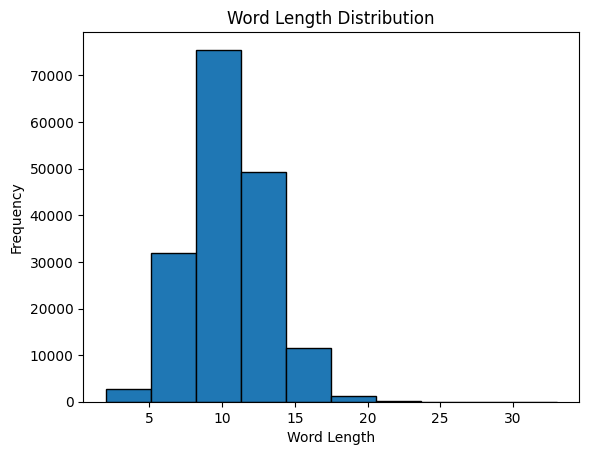

In [23]:
plt.hist(df['word_len'], bins=10, edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Word Length Distribution')
plt.show()

In [24]:
def plot_histogram(df, kind, lang):
    """Genera un histograma de frecuencia para una columna específica
    en un DataFrame.

    Parameters:
    ----------
    df : pd.DataFrame
        DataFrame que contiene los datos para generar el histograma.
    kind : str
        Nombre de la columna para la cual se generará el histograma.
    lang : str
        Idioma asociado a los datos.

    Returns:
    -------
    None
        Esta función muestra el histograma usando matplotlib.
    """
    counts = df[kind].value_counts().head(30)
    plt.bar(counts.index, counts.values)
    plt.xlabel(kind)
    plt.ylabel('Frequency')
    plt.title(f'{kind} Frequency Graph for {lang}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

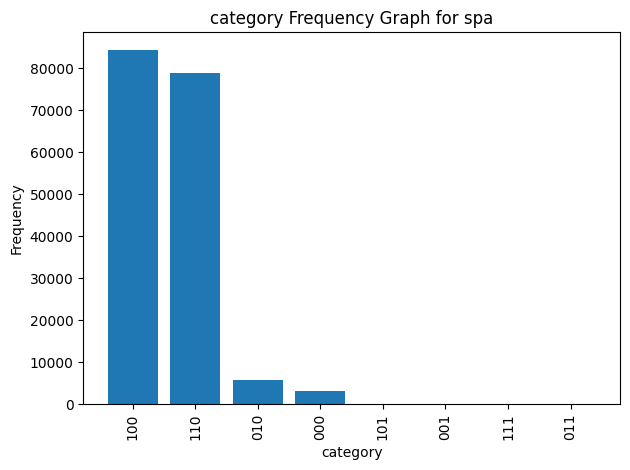

In [25]:
plot_histogram(df, "category", "spa")

#### Ejemplo 🥑: Adivina, adivinador, probabilidad del tipo de morfemas

- No todos los afijos son iguales. Algunos sirven para conjugar (Flexivos) y otros para crear conceptos nuevos (Derivativos).
- Aprovechando que el dataset de SIGMORPHON nos dice si una palabra es de tipo `Inflection` (100) o `Derivation` (010) calculemos qué tan probable es que un morfema sea flexivo o derivativo.


In [26]:
def analyze_morpheme_types(df: pd.DataFrame) -> pd.DataFrame:
    inflection_counts = defaultdict(int)
    derivation_counts = defaultdict(int)
    total_counts = defaultdict(int)

    for _, row in df.iterrows():
        morphemes = row['morph'] 
        category = row['category']

        # Con base en SIGMORPHON:
        # Pos 0: Inflection, Pos 1: Derivation
        is_inflection = category[0] == '1'
        is_derivation = category[1] == '1'

        for morph in morphemes:
            clean_morph = morph.replace("@@", "")

            # Ignoramos morfemas muy cortos o vacíos
            if len(clean_morph) < 2:
                continue

            total_counts[clean_morph] += 1
            if is_inflection:
                inflection_counts[clean_morph] += 1
            if is_derivation:
                derivation_counts[clean_morph] += 1

    results = []
    for morph, total in total_counts.items():
        if total > 5:
            p_inflection = inflection_counts[morph] / total
            p_derivation = derivation_counts[morph] / total
            results.append({
                'morfema': morph,
                'total_freq': total,
                'prob_flexion': round(p_inflection, 3),
                'prob_derivacion': round(p_derivation, 3)
            })

    return pd.DataFrame(results).sort_values(by='total_freq', ascending=False)

In [27]:
morph_stats = analyze_morpheme_types(df)

#### Los morfemas más "Gramaticales" (Flexivos)

Deberíamos ver terminaciones verbales y plurales.

In [28]:
rprint("Top Morfemas Flexivos:")
rprint(morph_stats.sort_values(by=['prob_flexion', "total_freq"], ascending=False).head(10))

Top Morfemas Flexivos:

morfema  total_freq  prob_flexion  prob_derivacion
54    emos       14230           1.0            0.522
25    ando       11765           1.0            0.535
13      ad        9840           1.0            0.531
38     les        7833           1.0            0.487
26     las        7829           1.0            0.498
79      le        7780           1.0            0.499
40     nos        7735           1.0            0.507
48     los        7729           1.0            0.507
9       la        7711           1.0            0.499
20      lo        7668           1.0            0.496

#### Los morfemas más "Léxicos" (Derivativos)

Deberíamos ver sufijos que cambian sustantivos a adjetivos, etc.

In [29]:
rprint("Top Morfemas Derivativos:")
rprint(morph_stats.sort_values(by=['prob_derivacion', "total_freq"], ascending=False).head(10))

Top Morfemas Derivativos:

morfema  total_freq  prob_flexion  prob_derivacion
15       ar       38717         0.982              1.0
10      des        9659         0.979              1.0
32      ear        8469         0.981              1.0
88       re        7150         0.985              1.0
262    ecer        1350         0.971              1.0
172      al        1196         0.830              1.0
295      ón         856         0.846              1.0
65       ex         853         0.912              1.0
42      pre         810         0.980              1.0
115  ificar         778         0.979              1.0

#### Morfosintaxis

- Etiquetas que hacen explícita la funcion gramatical de las palabras en una oración
- Determina la función de la palabra dentro la oración (por ello se le llama Partes del Discurso)
- Se le conoce tambien como **Análisis morfosintáctico**: es el puente entre la estructura de las palabras y la sintaxis
- Permiten el desarrollo de herramientas de NLP más avanzadas
- El etiquetado es una tarea que se puede abordar con técnicas secuenciales, por ejemplo, HMMs, CRFs, Redes neuronales

<center><img src="https://byteiota.com/wp-content/uploads/2021/01/POS-Tagging.jpg" height=500 width=500></center

#### Ejemplo

> El gato negro rie malvadamente

- El - DET
- gato - NOUN
- negro - ADJ
- ríe - VER

<center><img src="https://i.pinimg.com/originals/0e/f1/30/0ef130b255ea704625b2ad473701dee5.gif"></center

### Materia prima de otras tareas de NLP

- Named entity recognition (NER)
- Statistical language models
- Text generation
- Sentient analysis

## Etiquetado automático POS (*POS tagging*)

- El etiquetado POS es una tarea del NLP dónde se le asigna de forma automática una etiqueta según su función a cada palabra tomando en cuenta el contexto de la oración.

- En esta tarea se toma en cuenta cierta estructura de la oración.

- En un enfoque probabilístico queremos obtener: $P(\overrightarrow{x},\overrightarrow{y})$


donde:
- $\overrightarrow{x}$ = $<x_1,x_2,...,x_n>$
- $\overrightarrow{y}$ = $<y_1,y_2,...,y_n>$
- $x_i = palabra$ y $y_i = etiqueta\ POS$

### Un primer acercamiento: Hidden Markov Models (HMM)

<center><img src="https://www.davidsbatista.net/assets/images/2017-11-11-HMM.png"></center>

$p(\overrightarrow{x},\overrightarrow{y}) = \displaystyle\prod_{i=1}^{n} p(y_i|y_{i-1}) ⋅ p(x_i|y_i)$

Donde:
- $\overrightarrow{y} = secuencia\ de\ etiquetas\ POS$
- $\overrightarrow{x} = secuencia\ de\ palabras$

### Suposición de Markov

> "The probability of a particular state is dependent only on the previous state"

#### Características

- Clasificador secuencial
    - Dada una secuencia de entrada se predice la secuencia de salida más probable
    - Se apreden los parámetros de secuencias previamente etiquetadas

### Componentes del framework HMM


- Estados (etiquetas): $T = t_1,t_2,...,t_n$
- Observaciones (palabras): $W = w_1,w_2,...,w_n$
- Estados iniciales y finales

#### Probabilidades asociadas a estados

- Matriz $A$ con las probabilidades de ir de un estado a otro
- Matriz $B$ con las probabilidades de que una observasión se genera a partir de un estado
- Probabilidades asociadas a los estados iniciales y finales

### ¿Qué soluciona HMM?

1. Aprender parámetros asociados con una secuencia de observación dada (training step)
    - Dada una lista de palabras y sus etiquetas POS asociadas, el modelo aprende la estructura dada
2. Aplicar un modelo HMM previamente entrenado
    - Dada una nueva oración nunca antes vista, se puede **predecir** la etiqueta POS asociada a cada palabra de dicha oración usando la estructura aprendida

### Corpus: `cess_esp`

 TODO: Información del corpus
 https://www.nltk.org/book/ch02.html#tab-corpora


In [11]:
# Descargando el corpus cess_esp: https://www.nltk.org/book/ch02.html#tab-corpora
nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to
[nltk_data]     /home/umoqnier/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [12]:
# Cargando oraciones
corpora = cess_esp.tagged_sents()

In [13]:
rprint(corpora[1])

[
    ('Una', 'di0fs0'),
    ('portavoz', 'nccs000'),
    ('de', 'sps00'),
    ('EDF', 'np00000'),
    ('explicó', 'vmis3s0'),
    ('a', 'sps00'),
    ('EFE', 'np00000'),
    ('que', 'cs'),
    ('el', 'da0ms0'),
    ('proyecto', 'ncms000'),
    ('para', 'sps00'),
    ('la', 'da0fs0'),
    ('construcción', 'ncfs000'),
    ('de', 'sps00'),
    ('Altamira_2', 'np00000'),
    (',', 'Fc'),
    ('al', 'spcms'),
    ('norte', 'ncms000'),
    ('de', 'sps00'),
    ('Tampico', 'np00000'),
    (',', 'Fc'),
    ('prevé', 'vmm02s0'),
    ('la', 'da0fs0'),
    ('utilización', 'ncfs000'),
    ('de', 'sps00'),
    ('gas', 'ncms000'),
    ('natural', 'aq0cs0'),
    ('como', 'cs'),
    ('combustible', 'ncms000'),
    ('principal', 'aq0cs0'),
    ('en', 'sps00'),
    ('una', 'di0fs0'),
    ('central', 'ncfs000'),
    ('de', 'sps00'),
    ('ciclo', 'ncms000'),
    ('combinado', 'aq0msp'),
    ('que', 'pr0cn000'),
    ('debe', 'vmip3s0'),
    ('empezar', 'vmn0000'),
    ('a', 'sps00'),
    ('funcionar', 'vmn0000'),
    ('en', 'sps00'),
    ('mayo_del_2002', 'W'),
    ('.', 'Fp')
]

In [10]:
def get_tags_map() -> dict:
    tags_raw = r.get(
        "https://gist.githubusercontent.com/vitojph/39c52c709a9aff2d1d24588aba7f8155/raw/af2d83bc4c2a7e2e6dbb01bd0a10a23a3a21a551/universal_tagset-ES.map"
    ).text.split("\n")
    tags_map = {line.split("\t")[0].lower(): line.split("\t")[1] for line in tags_raw}
    return tags_map


def map_tag(tag: str, tags_map=get_tags_map()) -> str:
    return tags_map.get(tag.lower(), "N/F")


def parse_tags(corpora: list[list[tuple]]) -> list[list[tuple]]:
    result = []
    for sentence in corpora:
        result.append([(word, map_tag(tag)) for word, tag in sentence])
    return result

In [14]:
corpora = parse_tags(corpora)

In [15]:
rprint(corpora[0])

[
    ('El', 'DET'),
    ('grupo', 'NOUN'),
    ('estatal', 'ADJ'),
    ('Electricité_de_France', 'NOUN'),
    ('-Fpa-', '.'),
    ('EDF', 'NOUN'),
    ('-Fpt-', '.'),
    ('anunció', 'VERB'),
    ('hoy', 'ADV'),
    (',', '.'),
    ('jueves', 'NOUN'),
    (',', '.'),
    ('la', 'DET'),
    ('compra', 'NOUN'),
    ('del', 'ADP'),
    ('51_por_ciento', 'NUM'),
    ('de', 'ADP'),
    ('la', 'DET'),
    ('empresa', 'NOUN'),
    ('mexicana', 'ADJ'),
    ('Electricidad_Águila_de_Altamira', 'NOUN'),
    ('-Fpa-', '.'),
    ('EAA', 'NOUN'),
    ('-Fpt-', '.'),
    (',', '.'),
    ('creada', 'ADJ'),
    ('por', 'ADP'),
    ('el', 'DET'),
    ('japonés', 'ADJ'),
    ('Mitsubishi_Corporation', 'NOUN'),
    ('para', 'ADP'),
    ('poner_en_marcha', 'VERB'),
    ('una', 'DET'),
    ('central', 'NOUN'),
    ('de', 'ADP'),
    ('gas', 'NOUN'),
    ('de', 'ADP'),
    ('495', 'NUM'),
    ('megavatios', 'NOUN'),
    ('.', '.')
]

In [17]:
len(corpora)

6030

### Implementación de HMMs

In [19]:
# Separando en dos conjuntos, uno para entrenamiento y otro para pruebas
train_data, test_data = train_test_split(corpora, test_size=0.3, random_state=42)

In [20]:
# Comprobemos la longitud de la data
len(train_data), len(test_data)

(4221, 1809)

In [21]:
len(train_data) + len(test_data) == len(corpora)

True

#### Entrenamiento

In [ ]:
from nltk.tag import hmm

# Creando el modelo HMM usando nltk
trainer = hmm.HiddenMarkovModelTrainer()

# Hora de entrenar
hmm_model = trainer.train(train_data)

#### Resultados

In [ ]:
tagged_test_data = hmm_model.tag_sents([[word for word, _ in sent] for sent in test_data])

/home/umoqnier/.cache/pypoetry/virtualenvs/cl-2024-2-lab-wPHbJWRN-py3.9/lib/python3.9/site-packages/nltk/tag/hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
/home/umoqnier/.cache/pypoetry/virtualenvs/cl-2024-2-lab-wPHbJWRN-py3.9/lib/python3.9/site-packages/nltk/tag/hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
/home/umoqnier/.cache/pypoetry/virtualenvs/cl-2024-2-lab-wPHbJWRN-py3.9/lib/python3.9/site-packages/nltk/tag/hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


In [ ]:
tagged_test_data[0]

[('El', 'DET'),
 ('técnico', 'NOUN'),
 ('barcelonista', 'ADJ'),
 ('ha', 'VERB'),
 ('asegurado', 'VERB'),
 ('que', 'CONJ'),
 ('la', 'DET'),
 ('visita', 'NOUN'),
 ('de', 'ADP'),
 ('Gaspart', 'ADP'),
 ('ha', 'ADP'),
 ('contribuido', 'ADP'),
 ('a', 'ADP'),
 ('"', 'ADP'),
 ('sumar', 'ADP'),
 ('"', 'ADP'),
 (',', 'ADP'),
 ('y', 'ADP'),
 ('*0*', 'ADP'),
 ('ha', 'ADP'),
 ('argumentado', 'ADP'),
 ('que', 'ADP'),
 ('el', 'ADP'),
 ('encuentro', 'ADP'),
 ('con', 'ADP'),
 ('el', 'ADP'),
 ('presidente', 'ADP'),
 ('significa', 'ADP'),
 ('que', 'ADP'),
 ('en', 'ADP'),
 ('el', 'ADP'),
 ('Barcelona', 'ADP'),
 ('"', 'ADP'),
 ('todos', 'ADP'),
 ('van', 'ADP'),
 ('en', 'ADP'),
 ('la', 'ADP'),
 ('misma', 'ADP'),
 ('dirección', 'ADP'),
 ('"', 'ADP'),
 ('.', 'ADP')]

In [ ]:
# Extrayendo tags verdaderas vs tags predichas
y_true = [tag for sent in test_data for _, tag in sent]
y_pred = [tag for sent in tagged_test_data for _, tag in sent]

In [ ]:
y_true[:3]

['DET', 'NOUN', 'ADJ']

In [ ]:
y_pred[:3]

['DET', 'NOUN', 'ADJ']

In [ ]:
def report_accuracy(y_true: list, y_pred: list) -> defaultdict:

    label_accuracy_counts = defaultdict(lambda: {"correct": 0, "total": 0})

    for gold_tag, predicted_tag in zip(y_true, y_pred):
        label_accuracy_counts[gold_tag]["total"] += 1
        if gold_tag == predicted_tag:
            label_accuracy_counts[gold_tag]["correct"] += 1
    
    # Calculate and display the accuracy for each label
    print("Label\tAccuracy")
    for label, counts in label_accuracy_counts.items():
        accuracy = counts["correct"] / counts["total"] if counts["total"] > 0 else 0.0
        print(f"{label}\t{accuracy * 100:.2f}%")
    return label_accuracy_counts

In [ ]:
label_accuracy_counts = report_accuracy(y_true, y_pred)

Label	Accuracy
DET	32.70%
NOUN	26.55%
ADJ	21.27%
VERB	27.80%
CONJ	25.55%
ADP	99.91%
.	21.80%
PRON	27.66%
ADV	33.62%
NUM	14.90%
X	0.00%


### Hablemos de Métricas

#### Confusion Matrix (binaria)

Es una forma tabular de vizualizar el desempeño de un modelo de *Machine Learning (ML)*. En las columnas tenemos la cuenta de etiquetas predichas mientras que en las filas tenemos la cuenta de las etiquetas reales (o viceversa)

![](https://i1.wp.com/dataaspirant.com/wp-content/uploads/2020/08/3_confusion_matrix.png?ssl=1)

- **TP:** Etiquetas correctamente predichas como positivas. Ej: Se etiqueto un correo como spam y era spam
- **FP:** Etiquetas incorrectamente predichas. Ej: Se etiqueto un correo como spam y NO era spam
- **TN:** Etiquetas correctamente predichas como negativas. Ej: Se etiqueto un correo como no spam y era no spam
- **FN:** Etiquetas incorrectamente predichas como negativas. Ej: Se etiqueto un correo como no spam y era spam

#### Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

Es una de las métricas más sencillas usadas en *ML*. Define que tan exacto es el modelo. Por ejemplo, si de 100 etiquetas el modelo acerto en 90 tendremos un accuracy de 0.90 o 90%

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred_flat, y_test_flat))

0.9758977261035086


#### Precision = $\frac{TP}{TP + FP}$

Indica la relación entre las predicciones positivas correctas (SPAM es SPAM) con el total de predicciones de la clase sin importar si fueron correctas o no (Todo lo que fue marcado como SPAM correctamente con todo lo que fue marcado como SPAM incorrectamente). *De los correos etiquetados como SPAM cuandos fueron efectivamente SPAM*

In [ ]:
from sklearn.metrics import precision_score
print(precision_score(y_pred_flat, y_test_flat, average="macro"))

0.9697475680399225


#### Recall = $\frac{TP}{TP + FN}$

Indica la relacion entre las predicciones positivas correctas con el total de predicciones incorrectas de otras clases (Todo lo que no se marco como SPAM cuando si era SPAM). *Todos los correos que en realidad eran SPAM*

In [ ]:
from sklearn.metrics import recall_score
print(recall_score(y_pred_flat, y_test_flat, average="macro"))

0.969964437799256


#### F1-score = $\frac{2PR}{P + R}$

Es el promedio ponderado entre *precision* y *recall*. Toma en cuenta tanto los FP como los FN.

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(y_pred_flat, y_test_flat, average="macro"))

0.9698322789268278


#### Un ejemplo concreto

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/umoqnier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
#unseen_sentence = "La casa es grande y luminosa."
unseen_sentence = "La muchacha vio al dinosaurio con el telescopio"
#unseen_sentence = "El gato rie malvadamente"

# Tokenizando
tokenized_sentence = nltk.word_tokenize(unseen_sentence)

# Haciendo predicciones
predicted_tags = [tag for word, tag in hmm_model.tag(tokenized_sentence)]

print("Palabra \tPOS Tag (predicha)")
for word, tag in zip(tokenized_sentence, predicted_tags):
    print(f"{word}\t{tag}")

Palabra 	POS Tag (predicha)
La	DET
muchacha	ADP
vio	ADP
al	ADP
dinosaurio	ADP
con	ADP
el	ADP
telescopio	ADP


#### Comparando con modelos pre-entrenados

- [Model information](https://spacy.io/models/es)

In [ ]:
!python -m spacy download es_core_news_sm

In [ ]:
import spacy
# spacy.cli.download("") # Direct from python

nlp = spacy.load("es_core_news_sm")
doc = nlp(unseen_sentence)
print([(w.text, w.pos_) for w in doc])

[('La', 'DET'), ('muchacha', 'NOUN'), ('vio', 'VERB'), ('al', 'ADP'), ('dinosaurio', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('telescopio', 'NOUN')]


In [ ]:
from spacy import displacy
displacy.render(doc, style="dep", jupyter=True)

In [ ]:
test_sentences = [" ".join([word for word, _ in sent]) for sent in test_data][:10]

In [ ]:
docs = [nlp(sent) for sent in test_sentences]

In [ ]:
for doc in docs[:1]:
    print()
    print([(w.text, w.pos_) for w in doc])


[('El', 'DET'), ('técnico', 'NOUN'), ('barcelonista', 'ADJ'), ('ha', 'AUX'), ('asegurado', 'VERB'), ('que', 'SCONJ'), ('la', 'DET'), ('visita', 'NOUN'), ('de', 'ADP'), ('Gaspart', 'PROPN'), ('ha', 'AUX'), ('contribuido', 'VERB'), ('a', 'ADP'), ('"', 'PUNCT'), ('sumar', 'VERB'), ('"', 'PUNCT'), (',', 'PUNCT'), ('y', 'CCONJ'), ('*', 'PRON'), ('0', 'NUM'), ('*', 'NOUN'), ('ha', 'AUX'), ('argumentado', 'VERB'), ('que', 'SCONJ'), ('el', 'DET'), ('encuentro', 'NOUN'), ('con', 'ADP'), ('el', 'DET'), ('presidente', 'NOUN'), ('significa', 'VERB'), ('que', 'SCONJ'), ('en', 'ADP'), ('el', 'DET'), ('Barcelona', 'PROPN'), ('"', 'PUNCT'), ('todos', 'PRON'), ('van', 'VERB'), ('en', 'ADP'), ('la', 'DET'), ('misma', 'DET'), ('dirección', 'NOUN'), ('"', 'PUNCT'), ('.', 'PUNCT')]


In [ ]:
tagged_test_data[0]

[('El', 'DET'),
 ('técnico', 'NOUN'),
 ('barcelonista', 'ADJ'),
 ('ha', 'VERB'),
 ('asegurado', 'VERB'),
 ('que', 'CONJ'),
 ('la', 'DET'),
 ('visita', 'NOUN'),
 ('de', 'ADP'),
 ('Gaspart', 'ADP'),
 ('ha', 'ADP'),
 ('contribuido', 'ADP'),
 ('a', 'ADP'),
 ('"', 'ADP'),
 ('sumar', 'ADP'),
 ('"', 'ADP'),
 (',', 'ADP'),
 ('y', 'ADP'),
 ('*0*', 'ADP'),
 ('ha', 'ADP'),
 ('argumentado', 'ADP'),
 ('que', 'ADP'),
 ('el', 'ADP'),
 ('encuentro', 'ADP'),
 ('con', 'ADP'),
 ('el', 'ADP'),
 ('presidente', 'ADP'),
 ('significa', 'ADP'),
 ('que', 'ADP'),
 ('en', 'ADP'),
 ('el', 'ADP'),
 ('Barcelona', 'ADP'),
 ('"', 'ADP'),
 ('todos', 'ADP'),
 ('van', 'ADP'),
 ('en', 'ADP'),
 ('la', 'ADP'),
 ('misma', 'ADP'),
 ('dirección', 'ADP'),
 ('"', 'ADP'),
 ('.', 'ADP')]

In [ ]:
y_spacy_pred = []
for doc in docs:
    y_spacy_pred.extend([word.pos_ for word in doc])

In [ ]:
y_spacy_pred[:3]

['DET', 'NOUN', 'ADJ']

In [ ]:
label_count = report_accuracy(y_true, y_spacy_pred)

Label	Accuracy
DET	18.87%
NOUN	22.95%
ADJ	11.76%
VERB	10.00%
CONJ	0.00%
ADP	16.00%
.	0.00%
PRON	0.00%
ADV	0.00%
NUM	0.00%


In [ ]:
label_count

defaultdict(<function __main__.report_accuracy.<locals>.<lambda>()>,
            {'DET': {'correct': 10, 'total': 53},
             'NOUN': {'correct': 14, 'total': 61},
             'ADJ': {'correct': 2, 'total': 17},
             'VERB': {'correct': 4, 'total': 40},
             'CONJ': {'correct': 0, 'total': 20},
             'ADP': {'correct': 8, 'total': 50},
             '.': {'correct': 0, 'total': 38},
             'PRON': {'correct': 0, 'total': 14},
             'ADV': {'correct': 0, 'total': 13},
             'NUM': {'correct': 0, 'total': 4}})

### ¿Limitaciones?

- Cada estado depende exclusivamente de su predecesor inmediato
    - Dependencias limitadas
- Cada observación depende exclusivamente del estado actual
- Probabilidades estáticas
    - Ejemplo, si veo un par de tags `(V) -> (S)` no importa si esta al inicio, en medio o al final de la oración la probabilidad siempre será la misma

![](https://3.bp.blogspot.com/-pPGGqs462yw/T1ol64kj9uI/AAAAAAAAAKI/CDCiH1IJodE/w1200-h630-p-k-nu/patricio.jpg)

## Sobrepasando las fronteras: _Conditional Random Fields (CRFs)_

- Modelo de gráficas **no dirigido**. Generaliza los *HMM*
    - Adiós a la *Markov assuption*
    - Podemos tener cualquier dependencia que queramos entre nodos
    - Nos enfocaremos en un tipo en concreto: *LinearChain-CRFs* ¡¿Por?!

<center><img width=300 src="https://i.kym-cdn.com/entries/icons/original/000/032/676/Unlimited_Power_Banner.jpg"></center>


- Modela la probabilidad **condicional** $P(Y|X)$
    - Modelo discriminativo
    - Probabilidad de un estado oculto dada **toda** la secuecia de entrada
![homer](https://media.tenor.com/ul0qAKNUm2kAAAAd/hiding-meme.gif)

- Captura mayor **número de dependencias** entre las palabras y captura más características
    - Estas se definen en las *feature functions* 🙀
- El entrenamiento se realiza aplicando gradiente decendente y optimización con algoritmos como [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS)


<center><img src="https://iameo.github.io/images/gradient-descent-400.gif"></center>


$P(\overrightarrow{y}|\overrightarrow{x}) = \frac{1}{Z} \displaystyle\prod_{i=1}^N exp\{w^T ⋅ \phi(y_{i-1}, y_i, \overrightarrow{x}, i)\}$

Donde:
- $\overrightarrow{y}$ = Etiquetas POS
- $\overrightarrow{x}$ = Palabras en una oración
- $w^T$ = Vector de pesos a aprender
- $\phi$ = Vector de *Features*
    - Calculado con base en un conjunto de *feature functions*
- $i$ = la posición actual en la oración
- $Z$ = factor de normalización

![](https://aman.ai/primers/ai/assets/conditional-random-fields/Conditional_Random_Fields.png)

Tomado de http://www.davidsbatista.net/blog/2017/11/13/Conditional_Random_Fields/

#### Feature functions

$\phi(y_{i-1}, y_i, \overrightarrow{x}, i)$

- Parte fundamental de los CRFs
- Cuatro argumentos:
    - Todos los datos observables $\overrightarrow{x}$ (conectar $x$ con cualquier $y$)
    - El estado oculto anterior $y_{i-1}$
    - El estado oculto actual $y_i$
    - El index del timestamp $i$
        - Cada feature list puede tener diferentes formas

- Aquí es donde está la flexibilidad del modelo
- Tantas *features* como queramos, las que consideremos que pueden ayudar a que el modelo tenga un mejor desempeño
    - Íntimamente ligadas a la lengua. Para mejor desempeño se debe hacer un análisis de sus características.
- Ejemplo:

```python
[
    "word.lower()",
    "EOS",
    "BOS",
    "pre-word",
    "nxt-word",
    "word-position",
    ...
]
```

### Implementación de CRFs

#### Feature lists

In [38]:
def word_to_features(sent, i):
    word = sent[i][0]
    features = {
        "word.lower()": word.lower(),
        "word[-3:]": word[-3:],
        "word[-2:]": word[-2:],
        "prefix_1": word[:1],
        "prefix_2": word[:2],
        "word.isupper()": word.isupper(),
        "word.istitle()": word.istitle(),
        "word.isdigit()": word.isdigit(),
        "word_len": len(word),
    }
    if i > 0:
        prev_word = sent[i - 1][0]
        features.update(
            {
                "prev_word.lower()": prev_word.lower(),
                "prev_word.istitle()": prev_word.istitle(),
            }
        )
    else:
        # Beginning of sentence
        features["BOS"] = True
    return features


# Extract features and labels
def sent_to_features(sent) -> list:
    return [word_to_features(sent, i) for i in range(len(sent))]


def sent_to_labels(sent) -> list:
    return [label for token, label in sent]

In [39]:
# ¿Cuantas oraciones tenemos disponibles?
len(corpora)

6030

In [40]:
# Preparando datos para el CRF
X = [[word_to_features(sent, i) for i in range(len(sent))] for sent in corpora]
y = [[pos for _, pos in sent] for sent in corpora]

In [ ]:
# Exploración de data estructurada
rprint(X[0])

In [42]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [43]:
assert len(X_train) + len(X_test) == len(corpora), "Something wrong with my split :("
assert len(y_train) + len(y_test) == len(corpora), "Something wrong with my split :("

#### Entrenamiento

In [44]:
# Initialize and train the CRF tagger: https://sklearn-crfsuite.readthedocs.io/en/latest/api.html
crf = CRF(
    algorithm="lbfgs",
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True,
)
try:
    crf.fit(X_train, y_train)
except AttributeError as e:
    print(e)

loading training data to CRFsuite: 100%|██████████| 4824/4824 [00:00<00:00, 6693.93it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 67101
Seconds required: 0.150

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.25  loss=336016.09 active=66226 feature_norm=0.50
Iter 2   time=0.09  loss=313256.93 active=66095 feature_norm=0.42
Iter 3   time=0.09  loss=307307.44 active=66431 feature_norm=0.48
Iter 4   time=0.10  loss=298685.79 active=66543 feature_norm=0.62
Iter 5   time=0.10  loss=257211.56 active=66394 feature_norm=1.71
Iter 6   time=0.09  loss=199907.39 active=66602 feature_norm=3.89
Iter 7   time=0.08  loss=163496.35 active=66803 feature_norm=6.24
Iter 8   time=0.09  loss=140937.32 active=66825 feature_norm=7.76
Iter 9   time=0.09  loss=121987.34 active=66599 feature_norm=9.84
Iter 

#### Evaluación

In [45]:
y_pred = crf.predict(X_test)

# Flatten the true and predicted labels
y_test_flat = [label for sent_labels in y_test for label in sent_labels]
y_pred_flat = [label for sent_labels in y_pred for label in sent_labels]

# Evaluate the model
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
rprint(report)

precision    recall  f1-score   support

           .       1.00      1.00      1.00      4820
         ADJ       0.91      0.91      0.91      2675
         ADP       1.00      1.00      1.00      6577
         ADV       0.96      0.95      0.95      1473
        CONJ       0.97      0.97      0.97      2149
         DET       0.99      0.99      0.99      5563
        NOUN       0.97      0.97      0.97      9005
         NUM       0.94      0.96      0.95       400
        PRON       0.95      0.94      0.94      1705
        VERB       0.98      0.98      0.98      4505
           X       1.00      0.50      0.67         4

    accuracy                           0.98     38876
   macro avg       0.97      0.92      0.94     38876
weighted avg       0.98      0.98      0.98     38876

# Tarea 1: Exploración de Niveles del lenguaje 🔭

### FECHA DE ENTREGA: 10 de Marzo 2026 at 11:59pm

### Fonética

1. Con base en el sistema de búsqueda visto en clase que recibe una palabra ortográfica y devuelve sus transcripciones fonológicas, proponga una solución para los casos en que la palabra buscada no se encuentra en el lexicón/diccionario.
    - ¿Cómo devolver o **aproximar** su transcripción fonológica?
    - Reutiliza el sistema de búsqueda visto en clase y mejóralo con esta funcionalidad.
    - Muestra al menos tres ejemplos

### Morfología

2. Elige tres lenguas del corpus que pertenezcan a familias lingüísticas distintas
   - Ejemplo: `spa` (Romance), `eng` (Germánica), `hun` (Urálica)
   - Para cada una de las tres lenguas calcula y compara:
       -  **Ratio morfemas / palabra**: El promedio de morfemas que componen las palabras
        -  **Indicé de Flexión / Derivación**: Del total de morfemas, ¿Qué porcentaje son etiquetas de flexión (`100`) y cuáles de derivación (`010`)?
3. Visualización
    - Genera una figura con **subplots** para comparar las lenguas lado a lado.
    - *Plot 1*: Distribución de la longitud de los morfemas
    - *Plot 2*: Distribución de las categorías (flexión, derivación, raíz, etc.)
4. Con base en esta información, responde la pregunta: *¿Cuál de las tres lenguas se comporta más como una lengua aglutinante y cuál como una lengua aislante?*
    - Justifica tu respuesta usando tus métricas y figuras

### EXTRA:

- Genera la [matriz de confusión](https://en.wikipedia.org/wiki/Confusion_matrix) para el etiquetador CRFs visto en clase
- Observando las etiquetas donde el modelo falló responde las preguntas:
    - ¿Por qué crees que se confundió?
    - ¿Es un problema de ambigüedad léxica (la palabra tiene múltiples etiquetas)?
    - ¿Qué *features* añadirías para solucionarlo?